# Modelo RNN Con Memoria (LSTM)

En este cuaderno se implementa una Red Neuronal Recurrente con memoria a largo plazo (LSTM) para la clasificación de texto.
Las redes LSTM están diseñadas para evitar el problema del desvanecimiento del gradiente y capturar dependencias a largo plazo en secuencias.

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report, accuracy_score

# Configuración del dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cpu


## Carga y Preprocesamiento de Datos

Se cargan los archivos `.npy` y se preparan los tensores.
Al igual que en el modelo simple, redimensionamos la entrada a `(N, 1, 384)`.

In [3]:
# Cargar datos
train_X = np.load('train_all.npy')
train_y = np.load('train_labels.npy')
valid_X = np.load('valid_all.npy')
valid_y = np.load('valid_labels.npy')
test_X = np.load('test_all.npy')
test_y = np.load('test_labels.npy')

# Convertir a tensores y redimensionar
X_train_tensor = torch.tensor(train_X, dtype=torch.float32).unsqueeze(1).to(device)
y_train_tensor = torch.tensor(train_y - 1, dtype=torch.long).to(device)

X_valid_tensor = torch.tensor(valid_X, dtype=torch.float32).unsqueeze(1).to(device)
y_valid_tensor = torch.tensor(valid_y - 1, dtype=torch.long).to(device)

X_test_tensor = torch.tensor(test_X, dtype=torch.float32).unsqueeze(1).to(device)
y_test_tensor = torch.tensor(test_y - 1, dtype=torch.long).to(device)

# DataLoaders
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train samples: {len(train_dataset)}")

Train samples: 1200000


## Modelo LSTM Optimizado

A continuación se presenta una arquitectura más robusta para este problema:
- **Stacked LSTM**: 2 capas para capturar características más complejas.
- **Dropout**: Para evitar el sobreajuste (overfitting), dado que tenemos un dataset grande pero embeddings fijos.
- **Hidden Size**: Aumentado a 256 para mayor capacidad.
- **Stateless**: Se mantiene stateless (estado se reinicia por batch) ya que cada reseña es independiente.

In [9]:
class OptimizedLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.3):
        super(OptimizedLSTMModel, self).__init__()
        # num_layers=2 crea una LSTM apilada
        # dropout se aplica entre capas LSTM (si num_layers > 1)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, 
                            batch_first=True, dropout=dropout)
        
        # Capa de normalización para estabilizar el entrenamiento
        self.bn = nn.BatchNorm1d(hidden_size)
        
        # Dropout adicional antes de la capa final
        self.dropout = nn.Dropout(dropout)
        
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x: (batch, seq_len, input_size)
        # out: (batch, seq_len, hidden_size)
        out, (h_n, c_n) = self.lstm(x)
        
        # Tomar el último paso de tiempo
        last_out = out[:, -1, :]
        
        # Aplicar BatchNorm y Dropout
        last_out = self.bn(last_out)
        last_out = self.dropout(last_out)
        
        out = self.fc(last_out)
        return out

# Instanciar el modelo optimizado
input_size = 384
hidden_size = 256  # Aumentado de 128
output_size = 5
num_layers = 2
dropout = 0.3

model = OptimizedLSTMModel(input_size, hidden_size, output_size, num_layers, dropout).to(device)
print("Modelo Optimizado:")
print(model)

Modelo Optimizado:
OptimizedLSTMModel(
  (lstm): LSTM(384, 256, num_layers=2, batch_first=True, dropout=0.3)
  (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=5, bias=True)
)


## Entrenamiento Avanzado

Se implementa un ciclo de entrenamiento robusto que incluye:
- **Early Stopping**: Detiene el entrenamiento si la validación no mejora después de 5 épocas.
- **Model Checkpointing**: Guarda los pesos del modelo con la mejor precisión en validación (`best_lstm_model.pth`).
- **Learning Rate Scheduler**: Reduce la tasa de aprendizaje si la pérdida de validación se estanca.

In [10]:
# Definir pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Scheduler para reducir el learning rate si la pérdida de validación no mejora
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

num_epochs = 20 # Aumentamos épocas ya que tenemos Early Stopping
best_valid_acc = 0.0
patience = 5
patience_counter = 0

# Listas para historial
train_loss_history = []
valid_loss_history = []
train_acc_history = []
valid_acc_history = []

print("Iniciando entrenamiento...")

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += y_batch.size(0)
        correct_train += (predicted == y_batch).sum().item()
        
    train_acc = 100 * correct_train / total_train
    avg_train_loss = train_loss / len(train_loader)
    
    # Validación
    model.eval()
    valid_loss = 0.0
    correct_valid = 0
    total_valid = 0
    
    with torch.no_grad():
        for X_batch, y_batch in valid_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_valid += y_batch.size(0)
            correct_valid += (predicted == y_batch).sum().item()
            
    valid_acc = 100 * correct_valid / total_valid
    avg_valid_loss = valid_loss / len(valid_loader)
    
    # Guardar métricas
    train_loss_history.append(avg_train_loss)
    valid_loss_history.append(avg_valid_loss)
    train_acc_history.append(train_acc)
    valid_acc_history.append(valid_acc)
    
    # Step del scheduler
    scheduler.step(avg_valid_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}] '
          f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}% | '
          f'Valid Loss: {avg_valid_loss:.4f}, Valid Acc: {valid_acc:.2f}%')
    
    # Guardar el mejor modelo
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), 'best_lstm_model.pth')
        print(f"--> Mejor modelo guardado con Acc: {valid_acc:.2f}%")
        patience_counter = 0
    else:
        patience_counter += 1
        
    # Early Stopping
    if patience_counter >= patience:
        print("Early stopping activado.")
        break

print("Entrenamiento finalizado.")

Iniciando entrenamiento...
Epoch [1/20] Train Loss: 1.1166, Train Acc: 50.83% | Valid Loss: 1.0687, Valid Acc: 53.04%
--> Mejor modelo guardado con Acc: 53.04%
Epoch [2/20] Train Loss: 1.0801, Train Acc: 52.49% | Valid Loss: 1.0560, Valid Acc: 53.76%
--> Mejor modelo guardado con Acc: 53.76%
Epoch [3/20] Train Loss: 1.0679, Train Acc: 53.10% | Valid Loss: 1.0498, Valid Acc: 53.90%
--> Mejor modelo guardado con Acc: 53.90%
Epoch [4/20] Train Loss: 1.0603, Train Acc: 53.47% | Valid Loss: 1.0467, Valid Acc: 53.99%
--> Mejor modelo guardado con Acc: 53.99%
Epoch [5/20] Train Loss: 1.0541, Train Acc: 53.72% | Valid Loss: 1.0419, Valid Acc: 54.19%
--> Mejor modelo guardado con Acc: 54.19%
Epoch [6/20] Train Loss: 1.0486, Train Acc: 53.97% | Valid Loss: 1.0426, Valid Acc: 54.24%
--> Mejor modelo guardado con Acc: 54.24%
Epoch [7/20] Train Loss: 1.0441, Train Acc: 54.14% | Valid Loss: 1.0409, Valid Acc: 54.57%
--> Mejor modelo guardado con Acc: 54.57%
Epoch [8/20] Train Loss: 1.0397, Train Acc

## Visualización de Resultados

Se grafican las curvas de pérdida y precisión para los conjuntos de entrenamiento y validación.

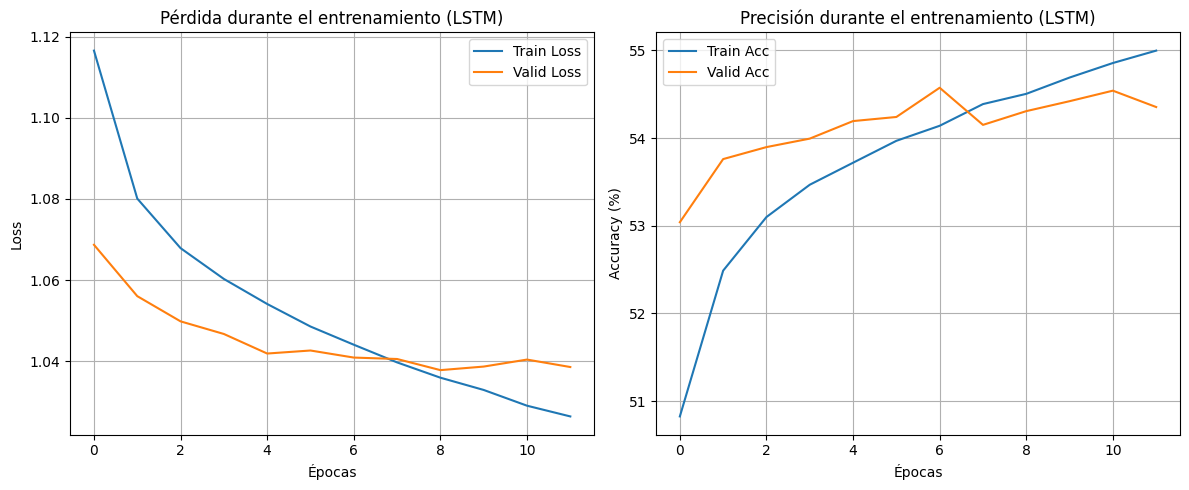

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Gráfica de Pérdida
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(valid_loss_history, label='Valid Loss')
plt.title('Pérdida durante el entrenamiento (LSTM)')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Gráfica de Precisión
plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Acc')
plt.plot(valid_acc_history, label='Valid Acc')
plt.title('Precisión durante el entrenamiento (LSTM)')
plt.xlabel('Épocas')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Evaluación

Evaluación del modelo LSTM en el conjunto de prueba.

In [12]:
# Cargar el mejor modelo guardado antes de evaluar
print("Cargando el mejor modelo guardado...")
model.load_state_dict(torch.load('best_lstm_model.pth'))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# Calcular métricas
accuracy = accuracy_score(all_labels, all_preds)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=['Clase 1', 'Clase 2', 'Clase 3', 'Clase 4', 'Clase 5']))

Cargando el mejor modelo guardado...
Test Accuracy: 54.28%

Classification Report:
              precision    recall  f1-score   support

     Clase 1       0.63      0.70      0.67      6000
     Clase 2       0.45      0.46      0.46      6000
     Clase 3       0.45      0.42      0.43      6000
     Clase 4       0.49      0.40      0.44      6000
     Clase 5       0.66      0.72      0.69      6000

    accuracy                           0.54     30000
   macro avg       0.54      0.54      0.54     30000
weighted avg       0.54      0.54      0.54     30000

Test Accuracy: 54.28%

Classification Report:
              precision    recall  f1-score   support

     Clase 1       0.63      0.70      0.67      6000
     Clase 2       0.45      0.46      0.46      6000
     Clase 3       0.45      0.42      0.43      6000
     Clase 4       0.49      0.40      0.44      6000
     Clase 5       0.66      0.72      0.69      6000

    accuracy                           0.54     30000
  

# Tabla de confusión

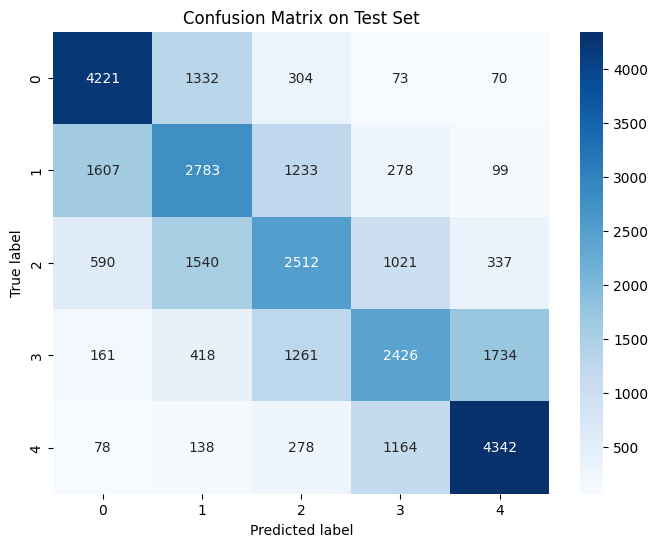

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Matriz de confusión
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix on Test Set")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()